# Natural Language Processing with Disaster Tweets

## Predict which Tweets are about real disasters and which ones are not


### Description
Twitter has become an important communication channel in times of emergency.
The ubiquitousness of smartphones enables people to announce an emergency they’re observing in real-time. Because of this, more agencies are interested in programatically monitoring Twitter (i.e. disaster relief organizations and news agencies).

But, it’s not always clear whether a person’s words are actually announcing a disaster. Take this example:
<img src="https://storage.googleapis.com/kaggle-media/competitions/tweet_screenshot.png" width="200" height="300"/>

The author explicitly uses the word “ABLAZE” but means it metaphorically. This is clear to a human right away, especially with the visual aid. But it’s less clear to a machine.

In this porject, I am challenged to build a NLP machine learning model that predicts which Tweets are about real disasters and which one’s aren’t. I have access to a dataset of 10,000 tweets that were hand classified.


### Data Preprocessing and EDA
- Import packages
- Loading data
- EDA

#### Import packages

In [1]:
# importing packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import string
import re
import nltk
from nltk.corpus import stopwords, wordnet
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score
from bs4 import BeautifulSoup
from wordcloud import WordCloud
import random

#### Loading the Data
Let's load our train and test data.

In [2]:
# Loading the train and test data for visualization & exploration.

train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [3]:
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [4]:
test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [5]:
print(train.shape)
print(test.shape)

(7613, 5)
(3263, 4)


#### EDA
- Deal with missing values
- Remove url, emojis, html tags and punctuations
- Lower cased
- Removed stopwords

In [6]:
print(train.isna().sum())
print('Total missing values: ', train.isna().sum().sum())

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64
Total missing values:  2594


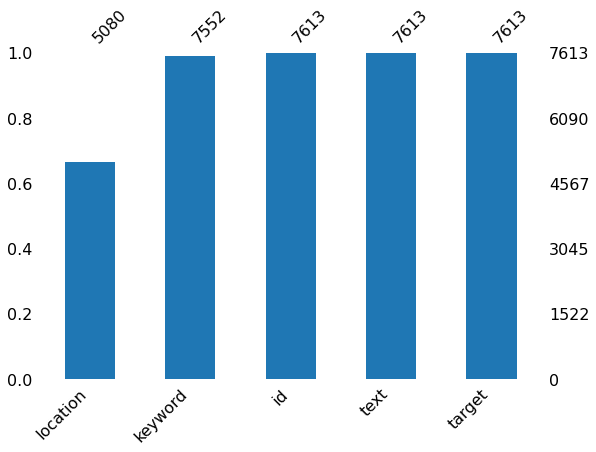

In [7]:
msno.bar(train, color = sns.color_palette("tab10")[0], sort = "ascending", figsize = (9, 6))
plt.show()

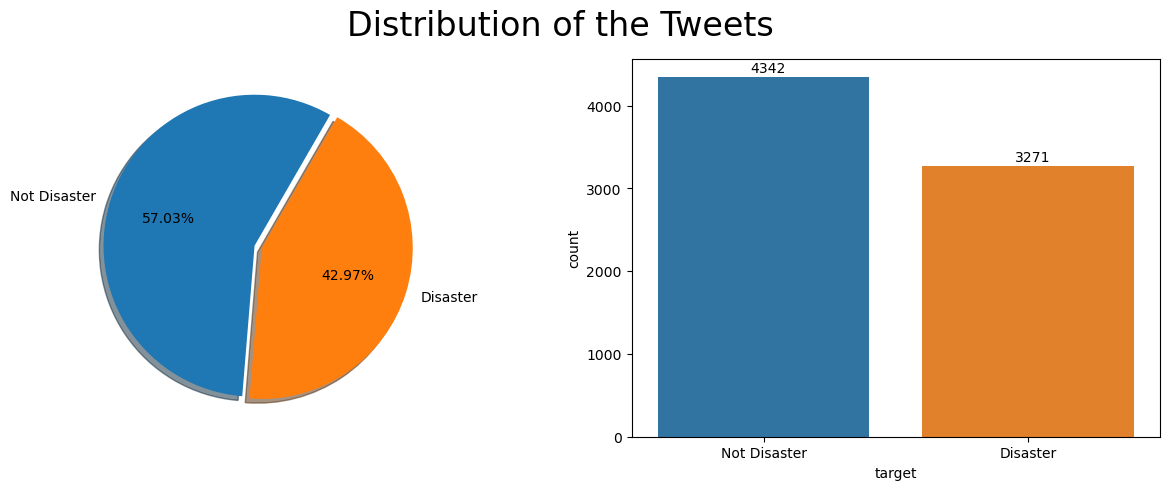

In [8]:
# Balanced?
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(15, 5), dpi=100)
# pie
axes[0].pie(train['target'].value_counts(),
            labels=['Not Disaster', 'Disaster'],
            autopct='%1.2f%%',
            shadow=True,
            explode=(0.05, 0),
            startangle=60)

xtick_labels = ['Not Disaster', 'Disaster']
# bar
ax = sns.countplot(x = train['target'], ax = axes[1])
for p in ax.patches:
    ax.annotate('{:.0f}'.format(p.get_height(), (p.get_height() / len(train['target'])) * 100), (p.get_x() + 0.35, p.get_height() + 60), fontsize = 10)
ax.set_xticklabels(labels = xtick_labels)
fig.suptitle('Distribution of the Tweets', fontsize=24)

plt.show()

In [9]:
train['target'].value_counts()

0    4342
1    3271
Name: target, dtype: int64

Since our data is unbalanced, so I downsampled the data.

In [10]:
# down sample the data
train_d = train[train['target'] == 1]
train_nd = train[train['target'] == 0]

train_nd_downsampled = train_nd.sample(train_d.shape[0])
train_nd_downsampled.shape[0]

3271

In [11]:
train_balanced = pd.concat([train_d, train_nd_downsampled])
train_balanced['target'].value_counts()

1    3271
0    3271
Name: target, dtype: int64

In [12]:
# data cleaning
# lowercase the text and remove urls and emojis in our text
nltk.download('punkt')

def clean_tweet_text(tweet):
    # convert to lowercase
    tweet = tweet.lower()
    
    # remove HTML tags using Beautiful Soup
    tweet = BeautifulSoup(tweet, "html.parser").get_text()
    
    # remove URLs
    tweet = re.sub(r'http\S+', '', tweet)
    tweet = tweet.replace("skea", "")
    
    # remove mentions (@username)
    tweet = re.sub(r'@\w+', '', tweet)

    # remove the "#" symbol from hashtags, keeping the content
    tweet = re.sub(r'#(\w+)', r'\1', tweet)

    # remove emojis 
    tweet = re.compile('['
                           u'\U0001F600-\U0001F64F'
                           u'\U0001F300-\U0001F5FF'
                           u'\U0001F680-\U0001F6FF'
                           u'\U0001F1E0-\U0001F1FF'
                           u'\U00002702-\U000027B0'
                           u'\U000024C2-\U0001F251'
                           ']+', flags=re.UNICODE).sub(r'', tweet)
    
    # remove punctuation
    tweet = tweet.translate(str.maketrans('', '', string.punctuation))

    # Remove special characters
    tweet = re.sub(r'[^a-zA-Z\s]', '', tweet) 
    # tokenize the tweet
    tokens = word_tokenize(tweet)
    
    # remove stopwords
    stop_words = set(stopwords.words('english'))
    filtered_tokens = [word for word in tokens if word not in stop_words]
    
    # join tokens back into a cleaned tweet
    cleaned_tweet = ' '.join(filtered_tokens)
    
    return cleaned_tweet

# ref: https://www.kaggle.com/code/yinchienpai/disaster-tweets-prediction-bert-pytorch

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\zifen\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [13]:
train_balanced['cleaned_text'] = train_balanced['text'].apply(clean_tweet_text)
train_balanced.head()

,id,keyword,location,text,target,cleaned_text
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,deeds reason earthquake may allah forgive us
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask canada
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,residents asked shelter place notified officer...
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,people receive wildfires evacuation orders cal...
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,got sent photo ruby alaska smoke wildfires pou...


In [14]:
test['cleaned_text'] = test['text'].apply(clean_tweet_text)
test.head()

,id,keyword,location,text,cleaned_text
0,0,NaN,NaN,Just happened a terrible car crash,happened terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s...",heard earthquake different cities stay safe ev...
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are...",forest fire spot pond geese fleeing across str...
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires,apocalypse lighting spokane wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan,typhoon soudelor kills china taiwan


### Model Training
I am using BERT as the disaster tweets classification model

In [15]:
import tensorflow as tf
from transformers import DistilBertTokenizerFast
from transformers import TFDistilBertForSequenceClassification
import pandas as pd
import numpy as np
import tensorflow_hub as hub
import tensorflow_text

In [16]:
# Split data into train and validation sets
train_tweets, val_tweets, train_labels, val_labels = train_test_split(train_balanced['cleaned_text'], train_balanced['target'], test_size = 0.2, stratify = train_balanced['target'], random_state = 666)

In [17]:
print(len(val_tweets))
print(len(val_labels))

1309
1309


#### bert_preprocess: TF2.0 Saved Model (v3) Overview:
This SavedModel is a companion of BERT models to preprocess plain text inputs into the input format expected by BERT. Check the model documentation to find the correct preprocessing model for each particular BERT or other Transformer encoder model.

BERT and its preprocessing were originally published by

Jacob Devlin, Ming-Wei Chang, Kenton Lee, Kristina Toutanova: "BERT: Pre-training of Deep Bidirectional Transformers for Language Understanding", 2018.
This model uses a vocabulary for English extracted from the Wikipedia and BooksCorpus (same as in the models by the original BERT authors). Text inputs have been normalized the "uncased" way, meaning that the text has been lower-cased before tokenization into word pieces, and any accent markers have been stripped.

This model has no trainable parameters and can be used in an input pipeline outside the training loop.
#### Bidirectional Encoder Representations from Transformers (BERT).
BERT (Bidirectional Encoder Representations from Transformers) provides dense vector representations for natural language by using a deep, pre-trained neural network with the Transformer architecture. It was originally published by

Jacob Devlin, Ming-Wei Chang, Kenton Lee, Kristina Toutanova: "BERT: Pre-training of Deep Bidirectional Transformers for Language Understanding", 2018.
This TF Hub model uses the implementation of BERT from the TensorFlow Models repository on GitHub at tensorflow/models/official/legacy/bert. It uses L=12 hidden layers (i.e., Transformer blocks), a hidden size of H=768, and A=12 attention heads. For other model sizes, see the BERT collection.

The weights of this model are those released by the original BERT authors. This model has been pre-trained for English on the Wikipedia and BooksCorpus. Text inputs have been normalized the "uncased" way, meaning that the text has been lower-cased before tokenization into word pieces, and any accent markers have been stripped. For training, random input masking has been applied independently to word pieces (as in the original BERT paper).

All parameters in the module are trainable, and fine-tuning all parameters is the recommended practice.

In [18]:
import tensorflow_hub as hub
bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
bert = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")

In [19]:
# Bert layers
text_input = tf.keras.layers.Input(shape = (), dtype = tf.string)
preprocessed_text = bert_preprocess(text_input)
output = bert(preprocessed_text)
# NN Layers
l = tf.keras.layers.Dropout(0.1)(output['pooled_output'])
l = tf.keras.layers.Dense(64, activation = 'relu')(l)
l = tf.keras.layers.Dense(1, activation = 'sigmoid')(l)
# construct final model
model = tf.keras.Model(inputs = [text_input], outputs = [l])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None,)]            0           []                               
                                                                                                  
 keras_layer (KerasLayer)       {'input_mask': (Non  0           ['input_1[0][0]']                
                                e, 128),                                                          
                                 'input_word_ids':                                                
                                (None, 128),                                                      
                                 'input_type_ids':                                                
                                (None, 128)}                                                  

In [20]:
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = [tf.keras.metrics.BinaryAccuracy(name = 'accuracy')])

In [21]:
history = model.fit(train_tweets, train_labels, epochs = 5)

Epoch 1/5


164/164 [==============================] - 40s 205ms/step - loss: 0.6185 - accuracy: 0.6625
Epoch 2/5
164/164 [==============================] - 34s 206ms/step - loss: 0.5560 - accuracy: 0.7233
Epoch 3/5
164/164 [==============================] - 34s 205ms/step - loss: 0.5351 - accuracy: 0.7344
Epoch 4/5
164/164 [==============================] - 34s 207ms/step - loss: 0.5276 - accuracy: 0.7430
Epoch 5/5
164/164 [==============================] - 35s 211ms/step - loss: 0.5190 - accuracy: 0.7485


In [22]:
model.evaluate(val_tweets, val_labels)

41/41 [==============================] - 9s 208ms/step - loss: 0.5031 - accuracy: 0.7632


[0.5030728578567505, 0.7631779909133911]

### Performance Evaluation

In [23]:
y_pred = model.predict(val_tweets)
y_pred = y_pred.flatten()

41/41 [==============================] - 9s 203ms/step


In [24]:
y_pred = np.where(y_pred > 0.5, 1, 0)
y_pred

array([0, 0, 1, ..., 0, 1, 1])

In [25]:
from sklearn.metrics import confusion_matrix, classification_report
cm = confusion_matrix(val_labels, y_pred)
cm

array([[501, 154],
       [156, 498]], dtype=int64)

Text(33.0, 0.5, 'Truth')

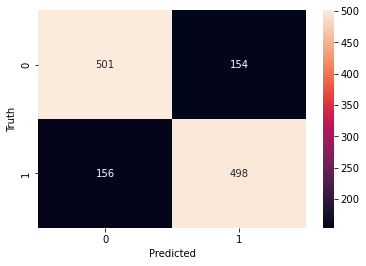

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.heatmap(cm, annot = True, fmt = 'd')
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [27]:
print(classification_report(val_labels, y_pred))

              precision    recall  f1-score   support

           0       0.76      0.76      0.76       655
           1       0.76      0.76      0.76       654

    accuracy                           0.76      1309
   macro avg       0.76      0.76      0.76      1309
weighted avg       0.76      0.76      0.76      1309



### Submission
Generating the submission file

In [28]:
sub_targets = model.predict(test['text'])
#sub_targets = sub_targets.flatten()
sub_targets = np.where(sub_targets > 0.5, 1, 0)

102/102 [==============================] - 21s 208ms/step


In [29]:
test['target'] = sub_targets.astype(int)
sub_df = test[['id', 'target']]
sub_df.to_csv('submission.csv', index = False)
sub_df

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1
...,...,...
3258,10861,0
3259,10865,1
3260,10868,1
3261,10874,1
